In [1]:
%matplotlib inline

In [105]:
import myUtils; reload(myUtils)
from myUtils import *

In [3]:
proj_path = '.'
model_path = proj_path + '/models'
data_path = '../../data/redux'

In [6]:
if not os.path.exists(model_path):
    os.mkdir(model_path)

The number of images to process in each batch (trial and error to find GPU memory limit)

In [4]:
batch_size = 100

Setup functions needed for defining the model

In [5]:
# setup array with mean of each color channel in ImageNet data set
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3, 1, 1))

In [6]:
# setup function to subtract the mean color from each pixel in an image
def vgg_preprocess(x):
    x = x - vgg_mean
    # reverse the pixel order from rgb to bgr (since VGG was trained using the openCV image loading functions, so expect bgr)
    return x[:, ::-1]

In [7]:
# Adds a convolution block to the model, consisting of the requested number layers
# with each layer consiting of a zero padded convolution with the requested number of filters
# and the block ended with a max pooling layer
def add_ConvBlock(layers, filters, model):
    for i in range(layers):
        # add a single zero to the start and end of each padding dimension (which is actually the default)
        model.add(ZeroPadding2D((1,1)))
        # add a 3 x 3 convolution with the given number of filters, all using REctified Linear Unit, max(0, x)
        # relu is NOT softmax, since softmax is (e^x_i) / sum(e^x_k), where 0 <= k < n
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    # add a max pooling layer that halves the image size in both the horizontal and vertical direction,
    # taking 2 pixels vertically and 2 pixels horizontally to make each new one
    # the stride defaults to match the pool size, but we declare it explicitly anyway, meaning we jump by the number of pixels
    # being pooled each time, so no pixel gets counted twice in the new image
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [8]:
# adds a block of fully connected layer and a dropout layer to prevent overfitting
def add_FCBlock(model):
    output_dim = 4096
    model.add(Dense(output_dim, activation='relu'))
    # dropout layer takes as a parameter the fraction of inputs to randomly set to 0 during training
    model.add(Dropout(0.5))

Create the VGG Model!

In [9]:
# where the VGG weights and classes are stored
server_path = 'http://www.platform.ai/models/'

In [10]:
# we'll be working with 244 x 244 images, after the image generator has preprocessed them
image_size = 224

In [11]:
def create_VGGModel(image_size=image_size):
    model = Sequential()
    # remove the mean value for each color channel to normalize the input
    model.add(Lambda(vgg_preprocess, input_shape=(3, image_size, image_size)))
    
    # due to max pooling the image size is halving after each block, so we can affort twice as many filters
    add_ConvBlock(2, 64, model)
    add_ConvBlock(2, 128, model)
    add_ConvBlock(3, 256, model)
    add_ConvBlock(3, 512, model)
    add_ConvBlock(3, 512, model)
    
    # switch from treating things as 2D to just 1D to classify
    model.add(Flatten())
    
    # create some fully connected blocks to work on the extract high-level features
    add_FCBlock(model)
    add_FCBlock(model)
    
    # add the final classification layer, for the 1000 possible output classes
    # we use softmax as it exponentially boosts the winner in one-hot-encoding and the values all add up 1.0, making a 
    # good probability distribution
    model.add(Dense(1000, activation='softmax'))
    
    # load the training VGG weights
    weights_file_name = 'vgg16.h5'
    server_weight_file_path = server_path + weights_file_name
    # pull down the weights file, caching it in ~/.keras/models
    local_weights_file_path = get_file(weights_file_name, server_weight_file_path, cache_subdir='models')
    model.load_weights(local_weights_file_path)
    
    return model

In [12]:
model = create_VGGModel(image_size)

C:\Users\mark.smith\Anaconda2\lib\site-packages\keras\keras\layers\core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [13]:
# returns the VGG imagenet output classifications
def get_vgg_classes():
    classes_file_name = 'imagenet_class_index.json'
    server_classes_path = server_path + classes_file_name
    local_classes_path = get_file(classes_file_name, server_classes_path, cache_subdir='models')
    with open(local_classes_path) as f:
        # parses json, which has the format { "0": ..., "162": ["n02088364", "beagle"], "1": ... }
        class_dict = json.load(f)
    # grab an array of just the class names (eg "beagle")
    # assumes dictionary keys correspond 1-1 with array index for number of entries
    return [class_dict[str(i)][1] for i in range(len(class_dict))]

### Load the image data, setting up necessary helpers (maybe move to util)

In [14]:
def get_batches(dir_name, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical', target_size=(image_size,image_size)):
    return gen.flow_from_directory(dir_name, target_size=target_size, class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [15]:
# use batch size of 1, since just doing preprocessing on cpu
validation_path = data_path + '/valid'

In [16]:
validation_batches = get_batches(validation_path, shuffle=False, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [17]:
train_path = data_path + '/train'

In [18]:
train_batches = get_batches(train_path, shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [22]:
def get_data(path, target_size=(image_size, image_size)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [23]:
#validation_data = get_data(validation_path)

In [24]:
#train_data = get_data(train_path)

In [26]:
#train_data.shape()

In [19]:
# may want to use keras.utils.np_utils.to_categorical() instead, since encodes all values between 0 and max,
# not just ones given, so is more consistent (but doesn't really matter when we only have 2 outputs)
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [20]:
val_classes = validation_batches.classes

In [21]:
trn_classes = train_batches.classes

In [22]:
val_labels = onehot(val_classes)

In [23]:
#val_labels = to_categorical(val_classes)

In [24]:
trn_labels = onehot(trn_classes)

In [25]:
trn_labels.shape

(23000L, 2L)

#### generate the VGG output of 1000 class probabilities per image

In [36]:
#trn_features = model.predict_generator(train_batches, train_batches.nb_sample)

KeyboardInterrupt: 

In [34]:
#val_features = model.predict_generator(validation_batches, validation_batches.nb_sample)

KeyboardInterrupt: 

In [ ]:
#save_array(model_path + 'train_lastlayer_features.bc', trn_features)

In [ ]:
#save_array(model_path + 'valid_lastlayer_features.bc', val_features)

#### or just load previously trained 1000 outputs if we're resuming from here

In [26]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

In [27]:
# create a linear model that takes the 1000 features from VGG and classifies into 2 (cat/dog)
linearModel = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])

In [28]:
linearModel.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

#### Fit the linear model

In [29]:
linearModel.fit(trn_features, trn_labels, batch_size, nb_epoch=3, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.1040 - acc: 0.9645 - val_loss: 0.0760 - val_acc: 0.9700
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0774 - acc: 0.9737 - val_loss: 0.0800 - val_acc: 0.9745
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0759 - acc: 0.9760 - val_loss

In [57]:
linearModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [30]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

#### Remove the VGG model's last classification layer so we can replace it with our own

In [25]:
model.pop()

In [26]:
# set all the existing layers to not change during training, so we just update our last layer
for layer in model.layers:
    layer.trainable = False

In [27]:
# now add our own layer with 2 output classes
model.add(Dense(2, activation='softmax'))

In [28]:
# recompile it with a suitably low learning rate, since we're just fine tuning the existing model
# TODO learn about Adam optimizer
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# retrain it!
train_batches = get_batches(train_path, shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [41]:
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=3,
                    validation_data=validation_batches, nb_val_samples=validation_batches.nb_sample)

Epoch 1/3
23000/23000 [==============================] - 254s - loss: 0.1267 - acc: 0.9647 - val_loss: 0.0672 - val_acc: 0.9795

In [43]:
fine_tuning1_path = model_path + '/fine_tuning1.h5'
model.save_weights(fine_tuning1_path)

In [45]:
model.evaluate_generator(validation_batches, validation_batches.nb_sample)

[0.039469933159853102, 0.98850001096725459]

In [31]:
model.load_weights(fine_tuning1_path)

In [32]:
model.evaluate_generator(validation_batches, validation_batches.nb_sample)

[0.039469933159853102, 0.98850001096725459]

In [53]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [33]:
# first dense layer is index 33
# create a generator to find first dense layer
first_dense_index = next(i for i,l in enumerate(model.layers) if type(l) is Dense)

In [34]:
# make all layers from the first dense onwards trainable
for i in xrange(first_dense_index, len(model.layers)):
    model.layers[i].trainable = True

In [36]:
# retrain it (important to do finetune of last layer first, so it doesn't start random and throw the earlier ones off)
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=3,
                    validation_data=validation_batches, nb_val_samples=validation_batches.nb_sample)

Epoch 1/3
23000/23000 [==============================] - 251s - loss: 0.0866 - acc: 0.9784 - val_loss: 0.0436 - val_acc: 0.9860

In [38]:
fine_tuning2_path = model_path + '/fine_tuning2.h5'
model.save_weights(fine_tuning2_path)

In [37]:
test_path = data_path + '/test'
test_batches = get_batches(test_path, shuffle=False, batch_size=batch_size, class_mode=None)

Found 12500 images belonging to 1 classes.


In [42]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [39]:
filenames = test_batches.filenames

In [44]:
print preds[:5]
print filenames[:5]

[[  1.71526578e-11   1.00000000e+00]
 [  1.00000000e+00   6.09830600e-13]
 [  9.99999881e-01   1.30565596e-07]
 [  1.63446492e-12   1.00000000e+00]
 [  1.31228001e-06   9.99998689e-01]]
['unknown\\1.jpg', 'unknown\\10.jpg', 'unknown\\100.jpg', 'unknown\\1000.jpg', 'unknown\\10000.jpg']


In [46]:
from PIL import Image

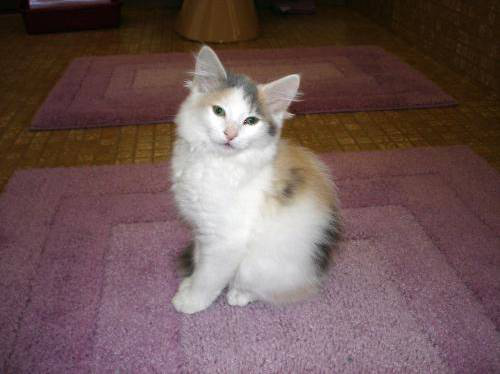

In [48]:
Image.open(test_path + '/' + filenames[1])

### save predictions and associated file names

In [49]:
ft2_preds_path = model_path + '/ft2_test_preds.dat'
ft2_filenames_path = model_path + '/ft2_test_filenames.dat'

In [50]:
save_array(ft2_preds_path, preds)

In [51]:
save_array(ft2_filenames_path, filenames)

#### play around with rendering images with labels

In [52]:
from keras.preprocessing import image

In [73]:
imageObjs = [image.load_img(test_path + '/' + filenames[i]) for i in xrange(4)]
titles = np.delete(preds[:4], 0, None)

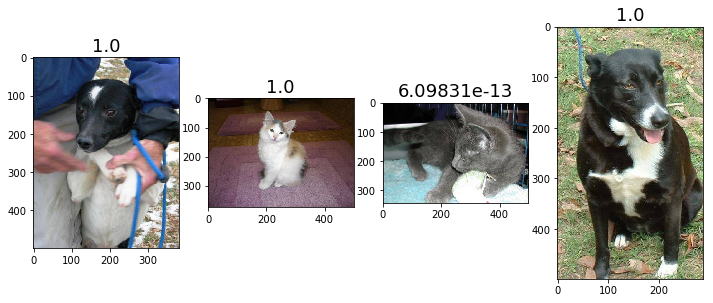

In [74]:
plots(imageObjs, titles=titles)

In [77]:
val_preds = model.predict_generator(validation_batches, validation_batches.nb_sample)

In [78]:
val_pred_labels = np.round(val_preds[:, 1])

In [80]:
val_real_labels = validation_batches.classes

In [123]:
correct_pred_indexes = np.where(val_pred_labels == val_real_labels)[0]
correct_pred_indexes

array([  24,   77,  127, ..., 1997, 1998, 1999], dtype=int64)

In [124]:
print "Found %d correct labels" % len(correct_pred_indexes)

Found 1192 correct labels


In [125]:
correct_sample_indexes = permutation(correct_pred_indexes)[:4]
correct_sample_indexes

array([825, 921, 634, 723], dtype=int64)

In [126]:
correct_sample_preds = [val_preds[i][0] for i in correct_sample_indexes]
correct_sample_images = [image.load_img(test_path + '/' + filenames[i]) for i in correct_sample_indexes]

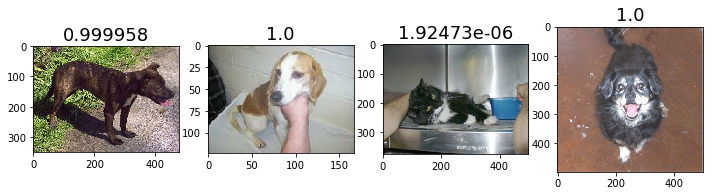

In [127]:
plots(correct_sample_images, titles=correct_sample_preds)

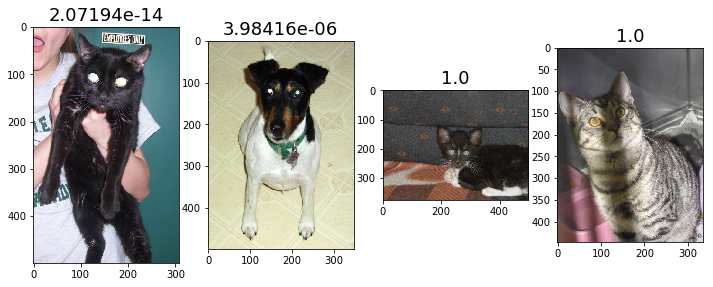

In [130]:
incorrect_pred_indexes = np.where(val_pred_labels != val_real_labels)[0]
incorrect_sample_indexes = permutation(correct_pred_indexes)[:4]
incorrect_sample_preds = [val_preds[i][1] for i in incorrect_sample_indexes]
incorrect_sample_images = [image.load_img(test_path + '/' + filenames[i]) for i in incorrect_sample_indexes]
plots(incorrect_sample_images, titles=incorrect_sample_preds)

In [140]:
#Grab the dog prediction column from the test data
isdog = preds[:,1]
# print "Raw Predictions: " + str(isdog[:5])
# print "Mid Predictions: " + str(isdog[(isdog < .8) & (isdog > .4)])
# print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

In [141]:
isdogOrig = isdog

In [142]:
isdog = isdogOrig.clip(min=0.001, max=0.9999)
len(isdog)

12500

In [145]:
# Extract imageIds from the filenames in our test/unknown directory 
filenames = test_batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])
ids

array([   1,   10,  100, ..., 9997, 9998, 9999])

In [144]:
# join the imageIds with the predictions
submission_data = np.stack([ids,isdog], axis=1)
submission_data[:5]

array([[  1.00000000e+00,   9.99899983e-01],
       [  1.00000000e+01,   1.00000005e-03],
       [  1.00000000e+02,   1.00000005e-03],
       [  1.00000000e+03,   9.99899983e-01],
       [  1.00000000e+04,   9.99899983e-01]])

In [146]:
submission_file_name = 'submission5.csv'
submission_path = model_path + '/' + submission_file_name
np.savetxt(submission_path, submission_data, fmt='%d,%.5f', header='id,label', comments='')